<a href="https://colab.research.google.com/github/86lekwenshiung/Neural-Network-with-Tensorflow/blob/main/07_Natural_Language_Processing_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Natural Language Processing in Tensorflow
___

The main goal of natural language processing (NLP) is to derive information from natural language.
Natural language is a broad term but you can consider it to cover any of the following:
* Text (such as that contained in an email, blog post, book, Tweet)
* Speech (a conversation you have with a doctor, voice commands you give to a smart speaker)

**What is NLP used for?**

Natural Language Processing is the driving force behind the following common applications:
* Language translation applications such as Google Translate
* Word Processors such as Microsoft Word and Grammarly that employ NLP to check grammatical accuracy of texts.
* Interactive Voice Response (IVR) applications used in call centers to respond to certain users’ requests.
* Personal assistant applications such as OK Google, Siri, Cortana, and Alexa.

**Workflow**
```
Download text -> Visualize Text -> turn into numbers (tokenization , embedding) -> build a model -> train the model to find patterns -> compare model -> ensemble model
```

`source` : 
* https://towardsdatascience.com/whatnlpscientistsdo-905aa987c5c0
* https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32
* https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e


# 0.0 Recurrent Neural Network

Another common term for NLP problems is sequence to sequence problems(seq2seq). RNN are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

**Typical Architecture of a RNN**

| Hyperparameter/Layer type | What does it do? | Typical values |
|---|---|---|
| Input text(s) | Target texts/sequences you'd like to discover patterns in | Whatever you can represent as text or a sequence |
| Input layer | Takes in target sequence | input_shape = [batch_size, embedding_size] or [batch_size , sequence_shape] |
| Text Vectorisation layer | Maps input sequence to layers | Multiple, can create with tf.keras.layers.preprocessing.TextVectorisation |
| Embedding | Turn mapping of text vectors to embedding matrix | Multiple, can create with tf.keras.layers.Embedding |
| RNN Cells | Find Pattern in Sequences | SimpleRNN , LSTM , GRU |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually Tanh (tf.keras.activations.tanh) |
| Pooling layer | Reduces the dimensionality of learned image features | Average (tf.keras.layers.GlobalAveragePooling1D) or Max (tf.keras.layers.GlobalMaxPool1D) |
| Fully connected layer | Further refines learned features from convolution layers | tf.keras.layers.Dense |
| Output layer | Takes learned features and outputs them in shape of target labels | output_shape = [number_of_classes] (e.g. disaster , Not Disaster) |
| Output activation | Adds non-linearities to output layer | tf.keras.activations.sigmoid (binary classification) or tf.keras.activations.softmax |


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split

import zipfile
import os

# 0.5 General Function
___

### TensorBoard Callbacks
___

In [2]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

### Classification Evaluation Metrics
___

In [3]:
def eval_classification(y_true , y_pred):

  from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

  # Define Scoring variables
  accuracy = accuracy_score(y_true , y_pred)
  precision = precision_score(y_true , y_pred)
  recall = recall_score(y_true , y_pred)
  f1_score = f1_score(y_true , y_pred)

  score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

  return score_dict

# 1.0 Getting Data from kaggle (Natural Language Processing with Disaster Tweets)
___

source : https://www.kaggle.com/philculliton/nlp-getting-started-tutorial

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-08-28 14:51:08--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-08-28 14:51:08 (106 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
# Unzip file
zip_ref = zipfile.ZipFile('nlp_getting_started.zip')
zip_ref.extractall()
zip_ref.close()

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### 1.1 Visualising Data
___

In [7]:
# Checking Training Data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_train = df_train.sample(frac = 1 , random_state = 42)
df_train.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
# Checking Test Data
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# Target True : False Ratio
df_train['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [11]:
random_index = random.randint(0 , len(df_train))
df_train[['text' , 'target']].head()

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0


In [12]:
random_index = random.randint(0 , len(df_train))

for row in df_train[['text' , 'target']][random_index : random_index +5].itertuples():
  _ , text , target = row

  print(f"Target: {target}" , "(Disaster)" if target > 0 else "(Not Disaster)")
  print(f'Text: {text}')
  print('-------\n')

Target: 0 (Not Disaster)
Text: New Ladies Shoulder Tote Handbag Women Cross Body Bag Faux Leather Fashion Purse - Full reÛ_ http://t.co/3PCNtcZoxv http://t.co/n0AkjM1e4B
-------

Target: 0 (Not Disaster)
Text: Trauma Team needs to come to the American E-shop.
-------

Target: 0 (Not Disaster)
Text: http://t.co/3nUiH6pkUi #shoes Asics GT-II Super Red 2.0 11 Ronnie Fieg Kith Red White 3M x gel grey volcano 2 http://t.co/2ufCC6gH3m
-------

Target: 1 (Disaster)
Text: @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
-------

Target: 0 (Not Disaster)
Text: INFANTRY Mens Lume Dial Army Analog Quartz Wrist Watch Sport Blue Nylon Fabric  - Full reaÛ_ http://t.co/hEP9k0XgHb http://t.co/80EBvglmrA
-------



### 1.2 Data Split Training and Validation
___

In [13]:
# Define X and y variables
train = df_train['text'].to_numpy()
val = df_train['target'].to_numpy()

In [14]:
train_sentences , val_sentences ,train_label , val_label = train_test_split(train , val , test_size = 0.1 , random_state  = 42)

In [15]:
print(f'Train Sentence: {train_sentences.shape}')
print(f'Val Sentence: {val_sentences.shape}')
print(f'Train Label: {train_label.shape}')
print(f'Val Label: {val_label.shape}')

Train Sentence: (6851,)
Val Sentence: (762,)
Train Label: (6851,)
Val Label: (762,)


### 1.3 Converting Text into Numbers
___

* Tokenization : Straight mapping from token to number , however model can get very big as no. of words increases.
* Embedding : Representation by vector , weighted matrix. Richer representation of relationship between tokens.

#### 1.3.1 Tokenization
___

In [16]:
# # Default Setting of TextVectorisation
# text_vectorizer = TextVectorization(max_tokens = None,
#                                     standardize = 'lower_and_strip_punctuation',
#                                     split = 'whitespace',
#                                     ngrams = None, # grouping of words
#                                     output_mode = 'int',
#                                     output_sequence_length = None,
#                                     pad_to_max_tokens = True) 

In [17]:
#   This example instantiates a `TextVectorization` layer that lowercases text, splits on whitespace, strips punctuation, and outputs integer vocab indices.

max_vocab_length = 10000  # Max number of words in our vocab
max_length = 15 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

In [18]:
text_vectorizer.adapt(train_sentences)

In [19]:
# Our max_length is set as 15 and our sentence only have 7 words. The rest of the 8 remaining words are padded with 0s.
sample_sentence = 'There is a flood in Bukit Timah'
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([ 74,   9,   3, 232,   4,   1,   1,   0,   0,   0,   0,   0,   0,
         0,   0])>

In [20]:
# Visualing random sentence from our training dataset.
random_sentence = random.choice(train_sentences)
print(f'Originial Sentence: {random_sentence}')
print('--------')
print(f'Vectorized Sentence: {text_vectorizer(random_sentence)}')

Originial Sentence: Skinny Jeans are Hazardous for Your Health! #socialnews http://t.co/pAQanenCeS
--------
Vectorized Sentence: [2703 2917   22  511   10   33  651 2292    1    0    0    0    0    0
    0]


In [21]:
# Checking the unique vocabulary
word_in_vocab = text_vectorizer.get_vocabulary()
print(f'Top 10 words: {word_in_vocab[:10]}')
print(f'Bottom 10 words: {word_in_vocab[-10:]}')

Top 10 words: ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
Bottom 10 words: ['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


#### 1.3.2 Embedding
___

* Key Parameters for embedding layer:
  - `input_dim` = size of our vocab
  - `output_dim` = size of our output embedding vector. A value of 100 would mean each token get represented by a vector 100 long
  - `input_length` = length of the sequences being passed to the embedding layer

In [22]:
embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length)
embedding

In [23]:
# Visualing random sentence from our training dataset.
random_sentence = random.choice(train_sentences)

print(f'Original Sentence : {random_sentence}')
print('--------')
print(f'Embedded Sentence : {embedding(text_vectorizer(random_sentence)).shape}')
print(f'Embedded Sentence : {embedding(text_vectorizer(random_sentence))}')

Original Sentence : Siren Test complete :: The test has concluded
--------
Embedded Sentence : (15, 128)
Embedded Sentence : [[ 2.59529687e-02  2.19255127e-02  3.06075253e-02 ...  1.62627809e-02
  -5.64940274e-05 -1.90951955e-02]
 [ 1.12803951e-02 -2.15843916e-02  3.91317941e-02 ... -2.29613073e-02
   3.08796652e-02  1.10706687e-02]
 [-4.97353673e-02  3.28742750e-02 -1.41871795e-02 ...  2.44693421e-02
   3.15127112e-02 -2.24266537e-02]
 ...
 [-2.35567242e-03  8.05502012e-03 -2.19145771e-02 ...  9.40399244e-03
   1.80891268e-02  3.53706516e-02]
 [-2.35567242e-03  8.05502012e-03 -2.19145771e-02 ...  9.40399244e-03
   1.80891268e-02  3.53706516e-02]
 [-2.35567242e-03  8.05502012e-03 -2.19145771e-02 ...  9.40399244e-03
   1.80891268e-02  3.53706516e-02]]


# 2.0 Modelling NLP with SKlearn , RNN , CNN , Transfer Learning
___


* Model 1 : Naive Bayes with TF-IDF encoder
* Model 2 : Feed-Forward neural network (dense)
* Model 3 : LSTM model (RNN)
* Model 4 : GRU model (RNN)
* Model 5 : Bidirectional - LSTM model (RNN)
* Model 6 : 1D CNN
* Model 7 : TF Hub Pretrained Feature Extractor
* Model 8 : TF Hub Pretrained Feature Extractor with 10% data.

### 2.0 Model 0 : Baseline Model with Naive Bayes with TF_IDF encoder
___


In [24]:
model_0 = Pipeline([
                    ('tfidf' , TfidfVectorizer()), # convert words to numbers using tfidf
                    ('clf' , MultinomialNB()) #model the text
])

model_0.fit(train_sentences , train_label)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [25]:
# Baseline model score
model_0.score(val_sentences , val_label)
model_0_preds = model_0.predict(val_sentences)

In [143]:
model_0_result = eval_classification(y_true = val_label , y_pred = model_0_preds)

### 2.1 Model 1 : Standard RNN (Dense)
___

**Type of RNN cells**

|Name|When to use|Code|
|---|---|---|
|LSTM|Default RNN layer for sequence|tf.keras.layers.LSTM|
|GRU|Perform very similiar to LSTM|tf.keras.layers.GRU|
|Bidirectional LSTM| Good for sequences which benefit from passing forward and backward|tf.keras.layers.Bidirectional|

All RNN have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/08-standard_rnn.png'>

source : http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [27]:
# Build model with the functional API

inputs = layers.Input(shape = (1,) , dtype = tf.string) # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the text into numbers
x = embedding(x) # create an embedding 
# x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs = inputs , outputs = outputs , name ='model_1')

In [28]:
# Observed that the output layer is not 1 output , but somehow related to our token count.
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
dense (Dense)                (None, 15, 1)             129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Build model with the functional API

inputs = layers.Input(shape = (1,) , dtype = tf.string) # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the text into numbers
x = embedding(x) # create an embedding 
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs = inputs , outputs = outputs , name ='model_1')

In [30]:
# Observed that after passing through the Pooling1D , the feature vector for each token is condense into 1 output
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Tensorboard Save directory
save_dir = 'model_logs'

model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_1 = model_1.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentences, val_label),
                        callbacks = [create_tensorboard_callback(dir_name = save_dir , 
                                                                 experiment_name = 'model_1_Dense')])

Saving Tensorboard log files to model_logs/model_1_Dense/20210828-145110
Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.6114 - accuracy: 0.6887 - val_loss: 0.5350 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4421 - accuracy: 0.8181 - val_loss: 0.4691 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3481 - accuracy: 0.8599 - val_loss: 0.4549 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2848 - accuracy: 0.8904 - val_loss: 0.4632 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2376 - accuracy: 0.9105 - val_loss: 0.4838 - val_accuracy: 0.7900


In [32]:
# Model 1 Score
model_1.evaluate(val_sentences , val_label)

24/24 [==============================] - 0s 2ms/step - loss: 0.4838 - accuracy: 0.7900


[0.4838237166404724, 0.7900262475013733]

In [33]:
# Checking test_prediction with actual label
model_1_preds = model_1.predict(val_sentences)
print(f' Sample Test Prediction : {model_1_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[0.986697  ]
 [0.01918247]
 [0.921702  ]
 [0.63788265]
 [0.06865248]
 [0.2331965 ]
 [0.12454778]
 [0.77552366]
 [0.46458152]
 [0.01026672]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [34]:
# formatting test prediction to 0 and 1 format

model_1_preds = tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [35]:
model_1_results = eval_classification(val_label , model_1_preds)
model_1_results

{'Accuracy': 0.7900262467191601,
 'F1 Score': 0.7444089456869011,
 'Precision': 0.8381294964028777,
 'Recall': 0.6695402298850575}

#### 2.1.1 Visualing via tensorflow projector
___
- [Tensorflow Projector](https://projector.tensorflow.org/)
- [Word Embedding](https://www.tensorflow.org/text/guide/word_embeddings)

In [36]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab) , words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [37]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
# For every unique token or vocab , there is 128 vectors representing it.
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights.shape

(10000, 128)

In [38]:
# Create Embedding files (we got this from Tensorflow's word embedding documentation)

import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [39]:
# Download file from Colab to upload to projector (we got this from Tensorflow's word embedding documentation)
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p align = 'center'>
  Extract from Tensorflow Projector for Model_1 (Load Vector.tsv and metadata.tsv)
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/08-tf_projector.png'>
</p>

### 2.2 Model 2 : LSTM (Long Short Term Memory)
___

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.
  - Forget Gate Layer : Look at previous chain and decide which to keep and remove
  - Input Gate Layer : Decide which value model update
  - Input Modulate Gate : Tanh layer and a subpart of the input gate. This make the information zero-mean and make convergence faster.
  - Output Gate : Determines what output(next Hidden State) to generate from the current Internal Cell State.

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/08-lstm_rnn.png'>

source : http://colah.github.io/posts/2015-08-Understanding-LSTMs/


**Typical Workflow**
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs / Dense) -> Output (label probability)
```

**Input non-linear function for RNN is `tanh`**
 - Compared to sigmoid, tanh squeezes the input and passes through the origin.


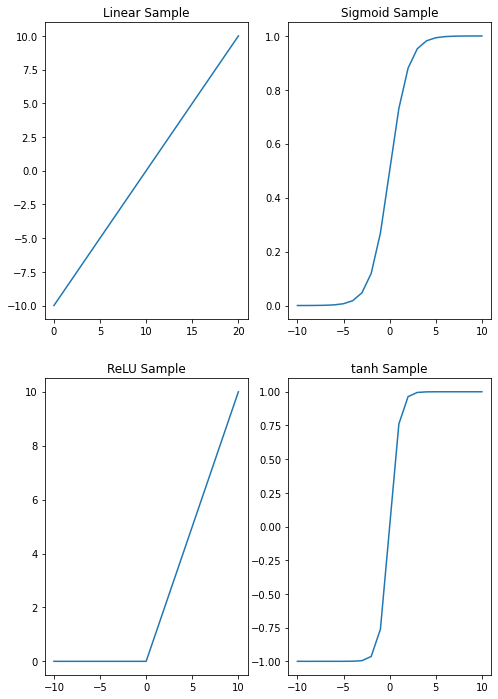

In [40]:

import tensorflow as tf
import matplotlib.pyplot as plt
# Passing a linear range
sample_linear = tf.range(-10,11 , dtype = tf.float32)

# 
def sigmoid(x):
  return 1/(1+tf.exp(-x))

def relu(x):
  return tf.maximum(0 , x)

def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))


# Passing linear range via the sigmoid and relu function
sample_sigmoid = sigmoid(sample_linear)
sample_relu = relu(sample_linear)
sample_tanh = tanh(sample_linear)

plt.figure(figsize = (8 , 12))

# Linear Activation - Same as Linear line
plt.subplot(2,2,1)
plt.plot(sample_linear)
plt.title('Linear Sample')

# Sigmoid Activation
plt.subplot(2,2,2)
plt.plot(sample_linear , sample_sigmoid)
plt.title('Sigmoid Sample')

# ReLU Activation
plt.subplot(2,2,3)
plt.plot(sample_linear , sample_relu)
plt.title('ReLU Sample');

# tanh Activation
plt.subplot(2,2,4)
plt.plot(sample_linear , sample_tanh)
plt.title('tanh Sample');

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,) , dtype = 'string') # inputs are 1D String
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units = 64 , return_sequences = True)(x) 
print(x.shape)
x = layers.LSTM(64)(x) # RNN is recurring , so it take it previous loop. Have to be same as previous
print(x.shape)
# x = layers.Dense(64 , activation = 'relu')(x)
# print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs = inputs , outputs = outputs , name= 'model_2')

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [42]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,362,497
Trainable params: 1,362,497
Non-trainable params: 0
_________________________________________________

In [43]:
model_2.compile(optimizer= tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_2 = model_2.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        callbacks = [create_tensorboard_callback(dir_name = save_dir,
                                                                 experiment_name = 'model_2_LSTM')],
                        validation_data = (val_sentences , val_label))

Saving Tensorboard log files to model_logs/model_2_LSTM/20210828-145130
Epoch 1/5
215/215 [==============================] - 12s 41ms/step - loss: 0.2238 - accuracy: 0.9153 - val_loss: 0.6114 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 7s 35ms/step - loss: 0.1606 - accuracy: 0.9409 - val_loss: 0.6675 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1341 - accuracy: 0.9517 - val_loss: 0.7119 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 8s 35ms/step - loss: 0.1052 - accuracy: 0.9577 - val_loss: 0.8281 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0782 - accuracy: 0.9675 - val_loss: 1.1904 - val_accuracy: 0.7743


In [44]:
# Checking test prediction with actual label
model_2_preds = model_2.predict(val_sentences)
print(f' Sample Test Prediction : {model_2_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[9.9992549e-01]
 [1.6003847e-04]
 [9.9990690e-01]
 [9.5938838e-01]
 [5.5151582e-03]
 [3.2530129e-03]
 [1.3097727e-01]
 [9.2065543e-01]
 [1.8019408e-02]
 [1.7407537e-04]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [45]:
# formatting prediction to 0 and 1 format

model_2_preds = tf.squeeze(tf.round(model_2_preds))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [46]:
# Getting the results
model_2_results = eval_classification(y_pred = model_2_preds, y_true = val_label )
model_2_results

{'Accuracy': 0.7742782152230971,
 'F1 Score': 0.7370030581039756,
 'Precision': 0.7875816993464052,
 'Recall': 0.6925287356321839}

### 2.3 Model 3 : GRU (Gated Recurrent Network)
___

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al.The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate. GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM. GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets.
Source : https://en.wikipedia.org/wiki/Gated_recurrent_unit


It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models.
<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/08-gru_rnn.png'>
source : http://colah.github.io/posts/2015-08-Understanding-LSTMs/


**Recap on flow process**
  ```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs / Dense) -> Output (label probability)
  ```

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.GRU(64 , return_sequences = True)(x) #return sequence = true if want to stack recurrent layers
print(x.shape)
x = layers.LSTM(42 , return_sequences = True)(x)
print(x.shape)
x = layers.GRU(99)(x)
print(x.shape)
# x = layers.Dense(64 , activation = 'relu')(x)
outputs = layers.Dense(1 , activation  = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs ,outputs , name = 'model_3')

(None, 15, 128)
(None, 15, 64)
(None, 15, 42)
(None, 99)


In [48]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 15, 64)            37248     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 42)            17976     
_________________________________________________________________
gru_1 (GRU)                  (None, 99)                42471     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 100 

In [49]:
model_3.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_3 = model_3.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentences , val_label),
                        callbacks = [create_tensorboard_callback(save_dir , 'model_3_GRU')])

Saving Tensorboard log files to model_logs/model_3_GRU/20210828-145215
Epoch 1/5
215/215 [==============================] - 16s 51ms/step - loss: 0.1368 - accuracy: 0.9539 - val_loss: 0.8317 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0718 - accuracy: 0.9691 - val_loss: 1.2764 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0618 - accuracy: 0.9724 - val_loss: 1.3255 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 10s 44ms/step - loss: 0.0527 - accuracy: 0.9764 - val_loss: 1.7254 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0504 - accuracy: 0.9784 - val_loss: 1.4138 - val_accuracy: 0.7730


In [50]:
model_3_preds = model_3.predict(val_sentences)
print(f' Sample Test Prediction : {model_3_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[9.9986172e-01]
 [2.2372462e-05]
 [9.9989557e-01]
 [9.9861562e-01]
 [9.6186996e-03]
 [6.0525239e-03]
 [2.5884825e-01]
 [8.9406300e-01]
 [1.4145374e-03]
 [1.5249754e-05]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [51]:
model_3_preds = tf.squeeze(tf.round(model_3_preds))
model_3_results = eval_classification(y_pred = model_3_preds, y_true = val_label )
model_3_results

{'Accuracy': 0.7729658792650919,
 'F1 Score': 0.7390648567119155,
 'Precision': 0.7777777777777778,
 'Recall': 0.7040229885057471}

### 2.4 Model_4 : Bi-directional LSTM (RNN)
___

Bi-directional RNN read text from both direction. For example:
 - the destruction caused by the bombing
 - bombing the by caused destruction the

<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/08-bi_directional.png'>
</p>

[Research Gate Source](https://www.researchgate.net/figure/Bi-directional-RNN-with-independent-weights-for-relation-classification-context-flow_fig4_316684826)

In [52]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64 , return_sequences = True))(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
print(x.shape)

model_4 = tf.keras.Model(inputs , outputs , name = 'model_4_bidirection')

(None, 15, 128)
(None, 15, 128)
(None, 64)
(None, 64)


In [53]:
# Observed that at bi-directional layers , the shape is (None ,15 , 128) because previous input x 2 ways.
model_4.summary()

Model: "model_4_bidirection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,420,097
Trainable params: 1,420,097
Non-trainable params: 0
_____________________________________

In [54]:
model_4.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_4 = model_4.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentences , val_label),
                        callbacks = [create_tensorboard_callback(save_dir , 'model_4_bidirectional')])

Saving Tensorboard log files to model_logs/model_4_bidirectional/20210828-145344
Epoch 1/5
215/215 [==============================] - 18s 56ms/step - loss: 0.1080 - accuracy: 0.9651 - val_loss: 1.0168 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0527 - accuracy: 0.9750 - val_loss: 1.0268 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 10s 48ms/step - loss: 0.0496 - accuracy: 0.9777 - val_loss: 1.1214 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 10s 48ms/step - loss: 0.0447 - accuracy: 0.9777 - val_loss: 1.2477 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 10s 47ms/step - loss: 0.0437 - accuracy: 0.9790 - val_loss: 1.3103 - val_accuracy: 0.7690


In [55]:
model_4.evaluate(val_sentences , val_label)

24/24 [==============================] - 0s 10ms/step - loss: 1.3103 - accuracy: 0.7690


[1.3102787733078003, 0.7690288424491882]

In [56]:
model_4_preds = model_4.predict(val_sentences)
print(f' Sample Test Prediction : {model_4_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[9.9985337e-01]
 [3.2097101e-04]
 [9.9984121e-01]
 [9.9354184e-01]
 [8.3957314e-03]
 [7.9353452e-03]
 [4.5379069e-01]
 [9.7984445e-01]
 [5.4143190e-02]
 [2.3096800e-04]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [57]:
# Model 4 results
model_4_preds = tf.squeeze(tf.round(model_4_preds))
model_4_results = eval_classification(y_true = val_label,
                                      y_pred = model_4_preds)
model_4_results

{'Accuracy': 0.7690288713910761,
 'F1 Score': 0.738872403560831,
 'Precision': 0.7638036809815951,
 'Recall': 0.7155172413793104}

### 2.5 Model_5 : 1D Convolution Neural Network for sequences
___

* Previous notebooks , we use CNN for images using Conv2D.
* Current sequences like text , we will use COnv2D.
* Recap previous workflow:
```
Input(text) ->Tokenization -> Embedding -> Layers (Conv1D , pooling) -> Outputs
```

In [58]:
import tensorflow as tf
from tensorflow.keras import layers

In [59]:
# Sample Visualing

embedding_text = embedding(text_vectorizer(['this is a test sentence'])) # turn target into token in text_vectorizer. In this example , we had set as 15.
print(embedding_text.shape)
conv_1d = layers.Conv1D(filters = 32,
                        kernel_size = 5, #look at 5 words at a time or ngram of 5
                        strides = 1, # how many words stride per time
                        activation = 'relu',
                        padding = 'valid')
conv_1d_output = conv_1d(embedding_text)
print(conv_1d_output.shape) # Shape at this layer goes from 15 to 11 because padding is valid
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # condenses all max value the 15 tokens convert into a single feature of 32.
print(max_pool_output.shape)

(1, 15, 128)
(1, 11, 32)
(1, 32)


In [60]:
inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5, # equivalent to ngram : how many words read at a time
                  activation = 'relu',
                  padding = 'same')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs , outputs , name = 'model_5_conv1d')

In [61]:
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [62]:
model_5.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_5 = model_5.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentences, val_label),
                        callbacks = [create_tensorboard_callback(save_dir , 'model_5_conv1d')])

Saving Tensorboard log files to model_logs/model_5_conv1d/20210828-145445
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1277 - accuracy: 0.9572 - val_loss: 0.8686 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0738 - accuracy: 0.9731 - val_loss: 0.9363 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0600 - accuracy: 0.9759 - val_loss: 1.0754 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0535 - accuracy: 0.9765 - val_loss: 1.1016 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0517 - accuracy: 0.9784 - val_loss: 1.1785 - val_accuracy: 0.7730


In [63]:
model_5.evaluate(val_sentences , val_label)

24/24 [==============================] - 0s 3ms/step - loss: 1.1785 - accuracy: 0.7730


[1.1784662008285522, 0.7729659080505371]

In [64]:
model_5_preds = model_5.predict(val_sentences)
print(f' Sample Test Prediction : {model_5_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[9.9999708e-01]
 [2.0325184e-04]
 [9.9983281e-01]
 [6.4495176e-02]
 [9.9200517e-02]
 [2.8685629e-03]
 [2.8698534e-01]
 [1.1404708e-01]
 [8.5658193e-02]
 [7.6166646e-07]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [65]:
model_5_preds = tf.squeeze(tf.round(model_5_preds))
model_5_results = eval_classification(y_true = val_label,
                                      y_pred = model_5_preds)
model_5_results

{'Accuracy': 0.7729658792650919,
 'F1 Score': 0.7334360554699537,
 'Precision': 0.7906976744186046,
 'Recall': 0.6839080459770115}

### 2.6 Model_6 : Tensorflow Hub Pretrained Model
___

[Univeral Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

In [66]:
# Sample example from Univseral Sentence Encoder
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607502 ... -0.03242778 -0.04575741
   0.05370456]
 [ 0.05080861 -0.01652428  0.01573781 ...  0.00976659  0.03170123
   0.01788119]], shape=(2, 512), dtype=float32)


In [68]:
# Create a Keras Layer using Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'model_6')

In [87]:
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
])

model_6.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

In [88]:
model_6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (KerasLayer)         (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
history_6 = model_6.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentences , val_label),
                        callbacks = [create_tensorboard_callback(save_dir , 'model_6_USE')])

Saving Tensorboard log files to model_logs/model_6_USE/20210828-150810
Epoch 1/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4804 - accuracy: 0.7900 - val_loss: 0.4339 - val_accuracy: 0.8110
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3978 - accuracy: 0.8281 - val_loss: 0.4297 - val_accuracy: 0.8189
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3792 - accuracy: 0.8375 - val_loss: 0.4171 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3570 - accuracy: 0.8467 - val_loss: 0.4164 - val_accuracy: 0.8228
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3297 - accuracy: 0.8596 - val_loss: 0.4234 - val_accuracy: 0.8215


In [90]:
model_6.evaluate(val_sentences , val_label)

24/24 [==============================] - 0s 9ms/step - loss: 0.4234 - accuracy: 0.8215


[0.42337024211883545, 0.8215222954750061]

In [91]:
model_6_preds = model_6.predict(val_sentences)
print(f' Sample Test Prediction : {model_6_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[0.9663745 ]
 [0.10449487]
 [0.9909884 ]
 [0.94636965]
 [0.04948583]
 [0.11228439]
 [0.0723314 ]
 [0.9437487 ]
 [0.6464796 ]
 [0.07735246]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [92]:
model_6_preds = tf.squeeze(tf.round(model_6_preds))
model_6_results = eval_classification(y_true = val_label , y_pred = model_6_preds)
model_6_results

{'Accuracy': 0.821522309711286,
 'F1 Score': 0.7988165680473372,
 'Precision': 0.823170731707317,
 'Recall': 0.7758620689655172}

### 2.7 Model_7 : Tensorflow Hub Pretrained Model (10% data)
___


In [95]:
# Recall our original Dataset
print(len(df_train))
df_train.head()

7613


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


#### 2.7.1 Example of Data Leakage
___

In [112]:
train_10_percent = df_train[['text' , 'target']].sample(frac = 0.1 ,random_state = 42)
train_sentences_10_percent = train_10_percent[['text']]
train_label_10_percent = train_10_percent[['target']]

print(len(train_label_10_percent.value_counts()))

2


In [111]:
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [122]:
# model_7 = tf.keras.models.clone_model(model_6)

model_7 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
] , name = 'model_7_10_percent')

model_7.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

model_7.summary()

Model: "model_7_10_percent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (KerasLayer)         (None, 512)               256797824 
_________________________________________________________________
dense_16 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [123]:
history_7 = model_7.fit(train_sentences_10_percent,
                        train_label_10_percent,
                        epochs = 5,
                        validation_data = (val_sentences , val_label),
                        callbacks = [create_tensorboard_callback(save_dir , 'model_7_10_precent')])

Saving Tensorboard log files to model_logs/model_7_10_precent/20210828-152721
Epoch 1/5
24/24 [==============================] - 4s 110ms/step - loss: 0.6813 - accuracy: 0.6557 - val_loss: 0.6528 - val_accuracy: 0.7861
Epoch 2/5
24/24 [==============================] - 1s 23ms/step - loss: 0.6064 - accuracy: 0.8068 - val_loss: 0.5273 - val_accuracy: 0.8150
Epoch 3/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4750 - accuracy: 0.8121 - val_loss: 0.4084 - val_accuracy: 0.8294
Epoch 4/5
24/24 [==============================] - 1s 23ms/step - loss: 0.3947 - accuracy: 0.8384 - val_loss: 0.3526 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 1s 39ms/step - loss: 0.3488 - accuracy: 0.8515 - val_loss: 0.3092 - val_accuracy: 0.8806


In [125]:
model_7.evaluate(val_sentences , val_label)

24/24 [==============================] - 0s 9ms/step - loss: 0.3092 - accuracy: 0.8806


[0.30924469232559204, 0.8805774450302124]

In [126]:
model_7_preds = model_7.predict(val_sentences)
print(f' Sample Test Prediction : {model_7_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[0.92307675]
 [0.11536941]
 [0.94481987]
 [0.764851  ]
 [0.01813   ]
 [0.2516079 ]
 [0.06155688]
 [0.8696269 ]
 [0.403954  ]
 [0.09116498]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [132]:
# Why does our lesser data have better score? -> Data Leakage
model_7_preds = tf.squeeze(tf.round(model_7_preds))
model_7_results = eval_classification(y_true = val_label,
                                      y_pred = model_7_preds)
model_7_results

{'Accuracy': 0.8805774278215223,
 'F1 Score': 0.8655834564254062,
 'Precision': 0.8905775075987842,
 'Recall': 0.8419540229885057}

1. Our original data split from above 6 model is via train_test_split from  the same df
2. Our model 7 10% train dataset is obtained via sample.frac from the df too.
3. There might be ovelap of data, thus data leakage when splitting dataset via 2 different steps.

#### 2.7.2 Re-splitting Dataset
___

In [136]:
train_10_percent = df_train['text'][:int(0.1*len(train_sentences))].to_numpy()
val_10_percent = df_train['target'][:int(0.1*len(train_sentences))].to_numpy()
len(train_10_percent) , len(val_10_percent)

(685, 685)

In [137]:
train_sentences_10_percent , val_sentences_10_percent ,train_label_10_percent , val_label_10_percent = train_test_split(train_10_percent , val_10_percent , test_size = 0.1 , random_state  = 42)

In [139]:
model_7 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
] , name = 'model_7_10_percent')

model_7.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_7 = model_7.fit(train_sentences_10_percent,
                        train_label_10_percent,
                        epochs = 5,
                        validation_data = (val_sentences_10_percent , val_label_10_percent),
                        callbacks = [create_tensorboard_callback(save_dir , 'model_7_10_precent_correct_split')])

Saving Tensorboard log files to model_logs/model_7_10_precent_correct_split/20210828-154608
Epoch 1/5
20/20 [==============================] - 2s 65ms/step - loss: 0.6769 - accuracy: 0.6071 - val_loss: 0.6520 - val_accuracy: 0.6377
Epoch 2/5
20/20 [==============================] - 0s 15ms/step - loss: 0.6008 - accuracy: 0.7792 - val_loss: 0.5836 - val_accuracy: 0.7826
Epoch 3/5
20/20 [==============================] - 0s 13ms/step - loss: 0.4806 - accuracy: 0.8182 - val_loss: 0.5379 - val_accuracy: 0.7826
Epoch 4/5
20/20 [==============================] - 0s 15ms/step - loss: 0.3857 - accuracy: 0.8425 - val_loss: 0.5281 - val_accuracy: 0.7826
Epoch 5/5
20/20 [==============================] - 0s 13ms/step - loss: 0.3282 - accuracy: 0.8718 - val_loss: 0.5371 - val_accuracy: 0.7536


In [140]:
model_7_preds = model_7.predict(val_sentences_10_percent)
print(f' Sample Test Prediction : {model_7_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[0.06225264]
 [0.7793475 ]
 [0.50805503]
 [0.1405232 ]
 [0.83638054]
 [0.17353162]
 [0.03919807]
 [0.03837115]
 [0.8039168 ]
 [0.86225   ]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [142]:
model_7_preds = tf.squeeze(tf.round(model_7_preds))
model_7_results = eval_classification(y_true = val_label_10_percent,
                                      y_pred = model_7_preds)
model_7_results

{'Accuracy': 0.7536231884057971,
 'F1 Score': 0.7118644067796611,
 'Precision': 0.75,
 'Recall': 0.6774193548387096}

# 3.0 Evaluating Models
___

In [155]:
df_model_summary = pd.DataFrame({'Baseline' : model_0_result,
                                 'Standard RNN' : model_1_results,
                                 'LSTM' : model_2_results,
                                 'GRU' : model_3_results,
                                 'Bi-direction LSTM' : model_4_results,
                                 '1D CNN' : model_5_results,
                                 'USE' : model_6_results,
                                 'USE_10_percent' : model_7_results})
df_model_summary = df_model_summary.T
df_model_summary

,Accuracy,Precision,Recall,F1 Score
Baseline,0.792651,0.886179,0.626437,0.734007
Standard RNN,0.790026,0.838129,0.669540,0.744409
LSTM,0.774278,0.787582,0.692529,0.737003
GRU,0.772966,0.777778,0.704023,0.739065
Bi-direction LSTM,0.769029,0.763804,0.715517,0.738872
1D CNN,0.772966,0.790698,0.683908,0.733436
USE,0.821522,0.823171,0.775862,0.798817
USE_10_percent,0.753623,0.750000,0.677419,0.711864


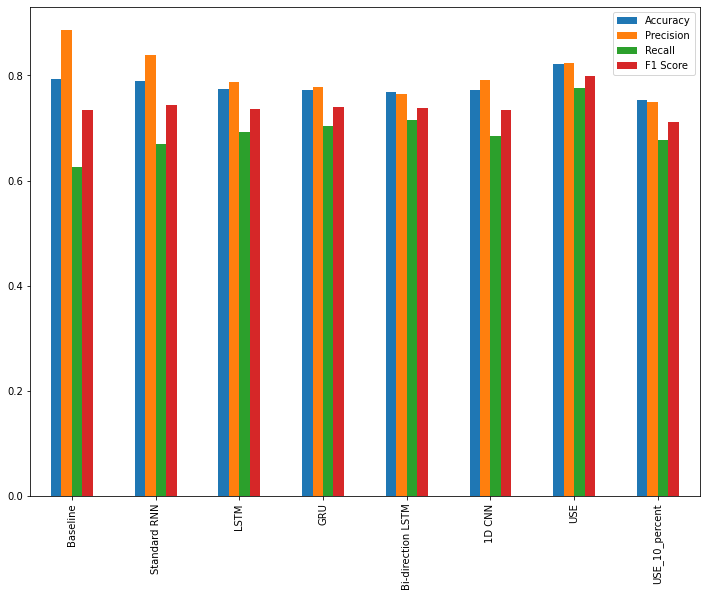

In [154]:
df_model_summary.plot(kind = 'bar' , figsize = (12,9)).legend(bbox_to_anchor = (1,1))

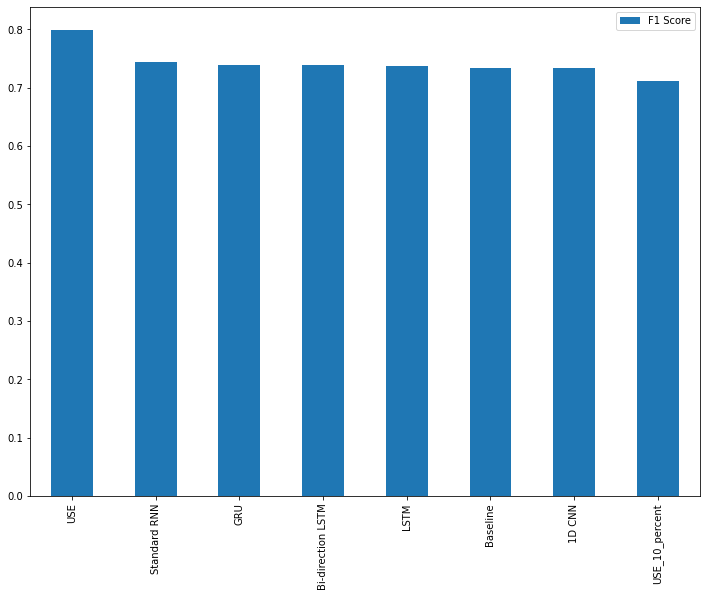

In [156]:
df_model_summary['F1 Score'].sort_values(ascending = False).plot(kind = 'bar' , figsize = (12,9)).legend(bbox_to_anchor = (1,1))

# 4.0 Evaluating Results in Tensorboard.dev
___

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
  --name 'NLP Modelling' \
  --description 'Training Results from Models' \
  --one_shot

Done. View your TensorBoard at https://tensorboard.dev/experiment/kN2nuYDtRAO1CQhPCQx6lw/

# 5.0 Saving and Loading our Model
___
- [Save & Load Tensorflow](https://www.tensorflow.org/tutorials/keras/save_and_load)
- `HDF5 format`
- `savedmodel`

In [163]:
# Saving Model via HDF5 format
model_6.save('model_6.h5')

In [166]:
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects = {'KerasLayer' : hub.KerasLayer})

In [167]:
# Checking Model Architecture is the same
loaded_model_6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (KerasLayer)         (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [169]:
# Checking Model Architecture is the same
model_6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (KerasLayer)         (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [170]:
# Saving Model via savedmodel
model_6.save('model_6_SavedModel')

INFO:tensorflow:Assets written to: model_6_SavedModel/assets


INFO:tensorflow:Assets written to: model_6_SavedModel/assets


In [171]:
import tensorflow_hub as hub
loaded_model_6_SavedModel = tf.keras.models.load_model('model_6_SavedModel',
                                                       custom_objects = {'KerasLayer' : hub.KerasLayer})

In [173]:
# Checking Model Architecture is the same
loaded_model_6_SavedModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (KerasLayer)         (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


# 6.0 Finding the Most Wrong Examples
___
- Since our model still is not perfect , what example is it getting wrong?
- And of these wrong example which one is it getting most wrong

In [175]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

--2021-08-28 16:26:27--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   114MB/s    in 8.3s    

2021-08-28 16:26:36 (110 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [176]:
!unzip 08_model_6_USE_feature_extractor.zip

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.index  
  inflating: 08_model_6_USE_feature_extractor/saved_model.pb  


In [179]:
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_11 (Dense)             (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [181]:
model_6_pretrained_preds = model_6.predict(val_sentences)
print(f' Sample Test Prediction : {model_6_pretrained_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[0.9663745 ]
 [0.10449487]
 [0.9909884 ]
 [0.94636965]
 [0.04948583]
 [0.11228439]
 [0.0723314 ]
 [0.9437487 ]
 [0.6464796 ]
 [0.07735246]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [184]:
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_preds))
eval_classification(y_pred = model_6_pretrained_preds,
                    y_true = val_label)

{'Accuracy': 0.821522309711286,
 'F1 Score': 0.7988165680473372,
 'Precision': 0.823170731707317,
 'Recall': 0.7758620689655172}

In [190]:
val_df = pd.DataFrame({'text' : val_sentences,
                       'target' : val_label,
                       'pred' : model_6_pretrained_preds,
                       'pred_score' : tf.squeeze(model_6.predict(val_sentences))})

val_df

,text,target,pred,pred_score
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.322138
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.856676
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.999135
3,@camilacabello97 Internally and externally scr...,1,0.0,0.200753
4,Radiation emergency #preparedness starts with ...,1,1.0,0.634187
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.112284
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.072331
759,FedEx will no longer transport bioterror patho...,0,1.0,0.943749
760,Crack in the path where I wiped out this morni...,0,1.0,0.646480


In [196]:
# Visualing False Positives
df_most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values(by = 'pred_score' , ascending = False)
df_most_wrong.head(15)

,text,target,pred,pred_score
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.971920
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.964333
628,@noah_anyname That's where the concentration c...,0,1.0,0.963034
303,Trafford Centre film fans angry after Odeon ci...,0,1.0,0.947399
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.946395
759,FedEx will no longer transport bioterror patho...,0,1.0,0.943749
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.934549
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.928340
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.907152
144,The Sound of Arson,0,1.0,0.893465


In [197]:
# Visualing False Negative
df_most_wrong.tail(15)

,text,target,pred,pred_score
59,You can never escape me. Bullets don't harm me...,1,0.0,0.072653
586,World War II book LIGHTNING JOE An Autobiograp...,1,0.0,0.072415
40,@BoyInAHorsemask its a panda trapped in a dogs...,1,0.0,0.062798
663,@GodOf_Mischief_ -of Loki's daggers she pulled...,1,0.0,0.059364
198,Perspectives on the Grateful Dead: Critical Wr...,1,0.0,0.058446
486,VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP ...,1,0.0,0.055661
221,going to redo my nails and watch behind the sc...,1,0.0,0.052433
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.050495
261,If I fall is men GOD @Praiz8 is d bomb well av...,1,0.0,0.049211
21,So I pick myself off the ground and swam befor...,1,0.0,0.048996


In [205]:
for row in df_most_wrong[:10].itertuples():
  _ , text , target , pred , pred_score = row
  print(f'Target : {target} ,Pred : {pred} Prob : {pred_score}')
  print(text)
  print('----------------------------------------------------------\n')

Target : 0 ,Pred : 1.0 Prob : 0.9719200730323792
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
----------------------------------------------------------

Target : 0 ,Pred : 1.0 Prob : 0.9643325805664062
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY
----------------------------------------------------------

Target : 0 ,Pred : 1.0 Prob : 0.9630340337753296
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
----------------------------------------------------------

Target : 0 ,Pred : 1.0 Prob : 0.9473992586135864
Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm   http://t.co/6GLDwx71DA
----------------------------------------------------------

Target : 0 ,Pred : 1.0 Prob : 0.9463952779769897
@freefromwolves GodsLove &amp; #thankU brother Danny for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming 

In [206]:
for row in df_most_wrong[-10:].itertuples():
  _ , text , target , pred , pred_score = row
  print(f'Target : {target} ,Pred : {pred} Prob : {pred_score}')
  print(text)
  print('----------------------------------------------------------\n')

Target : 1 ,Pred : 0.0 Prob : 0.05566138029098511
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK
----------------------------------------------------------

Target : 1 ,Pred : 0.0 Prob : 0.05243295431137085
going to redo my nails and watch behind the scenes of desolation of smaug ayyy
----------------------------------------------------------

Target : 1 ,Pred : 0.0 Prob : 0.050494641065597534
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
----------------------------------------------------------

Target : 1 ,Pred : 0.0 Prob : 0.04921111464500427
If I fall is men GOD @Praiz8 is d bomb well av always known dat since 2008 bigger u I pray sir
----------------------------------------------------------

Target : 1 ,Pred : 0.0 Prob : 0.04899626970291138
So I pick myself off the ground and swam before I drowned. Hit the bottom so hard I bounced twice suffice this time around is different.
-------

In [208]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 7.0 Making Prediction on test dataset
___

In [218]:
test_sentences = df_test['text'].to_list()
test_samples = random.sample(test_sentences , 10)

for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)} , Prob: {pred_prob}')
  print(test_sample)
  print('----------------------------------------------------\n') 

Pred: 0 , Prob: 0.44260373711586
Sounds pretty sensible for a mass murderer... https://t.co/qZZxFYSIU1
----------------------------------------------------

Pred: 1 , Prob: 0.5469158291816711
@MountSinaiNYC @Beingtweets @Susancares2x #onbeingwithKristaTippett This is important for women living w/HIV the science of trauma
----------------------------------------------------

Pred: 1 , Prob: 0.9186513423919678
2 Policemen receive bullet wounds Reports indicate 6-7 armed men attacked a police post.
----------------------------------------------------

Pred: 0 , Prob: 0.21204835176467896
AxWave enables a fast and accurate simulation of 2D and 3D seismic surveys in an acoustic medium #seismic #GPU #CPU http://t.co/OMX1NXAqpz
----------------------------------------------------

Pred: 0 , Prob: 0.08763569593429565
I hope you fall off a cliff.
----------------------------------------------------

Pred: 1 , Prob: 0.8274557590484619
Twin Storms Blow Through Calgary * 75 http://t.co/sIAKlSbdiP h